In [24]:
#  Compute Alphas as instructed
import pandas as pd
import numpy as np

def compute_alphas(file_path):
    df = pd.read_csv(file_path)
    
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.date
    
    df['typical_price'] = (df['close'] + df['high'] + df['low']) / 3
    df['tp_times_volume'] = df['typical_price'] * df['volume']

    # Function to calculate rolling sum within same day
    def same_day_rolling_sum(group):
        return group.rolling(window=24, min_periods=1).sum()

    # Group by day and calculate rolling sums
    df['cum_tp_volume'] = df.groupby('day')['tp_times_volume'].transform(same_day_rolling_sum)
    df['cum_volume'] = df.groupby('day')['volume'].transform(same_day_rolling_sum)
    
    df['vwap'] = np.where(
        df['cum_volume'] > 0,
        df['cum_tp_volume'] / df['cum_volume'],
        0 
    )
    
    df['alpha_A'] = np.sqrt(df['high'] * df['low']) - df['vwap']
    df['alpha_B'] = -1 * ((df['low']-df['close'])*pow(df['open'],5))/((df['low'] - df['high']) * pow(df['close'],5))
    df['alpha_C'] = (df['close']-df['open'])/(df['high']-df['low']) +0.001


    
    return df




In [25]:
#  Implement signals and exit entries
import numpy as np

def calculate_zscore_signals(df, lookback=24, threshold_std=1.5):
    for alpha in ['alpha_A', 'alpha_B', 'alpha_C']:
        df[f'{alpha}_zscore'] = (
            df[alpha] - df[alpha].rolling(window=lookback).mean()
        ) / df[alpha].rolling(window=lookback).std()
        
        df[f'{alpha}_signal'] = np.where(
            df[f'{alpha}_zscore'] > threshold_std, -1,
            np.where(df[f'{alpha}_zscore'] < -threshold_std, 1, 0)
        )
    return df

def combined_alpha_signals(df, entry_threshold=1.5, exit_threshold=0.5,lookback=24):
    df = calculate_zscore_signals(df, lookback=lookback, threshold_std=entry_threshold)
    
    df['combined_signal'] = np.where(
        ((df['alpha_A_signal'] == 1) |
        (df['alpha_C_signal'] == 1) )&
        (df['alpha_B_signal'] == 1), 1,
        np.where(
            ((df['alpha_A_signal'] == -1) |
            (df['alpha_C_signal'] == -1) ) &
            (df['alpha_B_signal'] == -1), -1,
            0
        )
    )
    
    df['exit_signal'] = (
        (abs(df['alpha_A_zscore']) < exit_threshold) & 
        (abs(df['alpha_B_zscore']) < exit_threshold) & 
        (abs(df['alpha_C_zscore']) < exit_threshold)
    )
    
    df['current_status'] = ""
    df['cumulative_returns'] = np.ones(len(df), dtype=np.float64)


    current_signal = 0
    for i in range(1, len(df)):
        if current_signal == 0:
            if df['combined_signal'].iloc[i] == 1:  
                current_signal = 1
                df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1] * (1 + df['p_n_l'].iloc[i]/100)
                df.loc[df.index[i], 'current_status'] = "LONG"
            elif df['combined_signal'].iloc[i] == -1:
                current_signal = -1
                df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1] * (1 - df['p_n_l'].iloc[i]/100)
                df.loc[df.index[i], 'current_status'] = "SHORT"
            else:
                df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1]
        
        else: 
            if df['exit_signal'].iloc[i]: 
                current_signal = 0
                df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1]
            else:
                if current_signal == 1:  
                    df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1] * (1 + df['p_n_l'].iloc[i]/100)
                    df.loc[df.index[i], 'current_status'] = "LONG"
                else: 
                    df.loc[df.index[i], 'cumulative_returns'] = df['cumulative_returns'].iloc[i-1] * (1 - df['p_n_l'].iloc[i]/100)
                    df.loc[df.index[i], 'current_status'] = "SHORT"
    
    return df



In [28]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_max_drawdown(cumulative_returns_input, dates):
    """
    Calculate maximum drawdown and corresponding peak/trough dates in O(n)
    
    Args:
    cumulative_returns_input: Series of cumulative returns
    dates: Series of corresponding dates
    
    Returns:
    tuple: (max_drawdown, peak_idx, trough_idx)
    """
    cumulative_returns = cumulative_returns_input.copy()
    max_drawdown = float('-inf')
    peak = cumulative_returns.iloc[0]
    peak_idx = 0
    curr_peak_idx = 0
    trough_idx = 0
    
    for i in range(len(cumulative_returns)):
        curr_value = cumulative_returns.iloc[i]
        
        # Update peak if we find a new high
        if curr_value > peak:
            peak = curr_value
            curr_peak_idx = i
        
        # Calculate current drawdown
        drawdown = (peak - curr_value) / peak
        
        # Update maximum drawdown if current drawdown is larger
        if drawdown > max_drawdown:
            max_drawdown = drawdown
            peak_idx = curr_peak_idx
            trough_idx = i
    
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Peak Index: {peak_idx}, Peak Value: {cumulative_returns.iloc[peak_idx]:.4f}, date: {dates.iloc[peak_idx].strftime('%Y-%m-%d')}")
    print(f"Trough Index: {trough_idx}, Trough Value: {cumulative_returns.iloc[trough_idx]:.4f}, date: {dates.iloc[trough_idx].strftime('%Y-%m-%d')}")
    
    return max_drawdown, peak_idx, trough_idx


def calculate_performance_metrics(df):
    df['daily_returns'] = df['cumulative_returns'].pct_change()
    
    risk_free_rate = 0 
    daily_rf = (1 + risk_free_rate)**(1/365) - 1
    excess_returns = df['daily_returns'] - daily_rf
    sharpe_ratio = (excess_returns.mean() / excess_returns.std())

    total_days = (df['date'].iloc[-1] - df['date'].iloc[0]).days
    total_return = df['cumulative_returns'].iloc[-1] / df['cumulative_returns'].iloc[0] - 1
    cagr = (1 + total_return)**(365/total_days) - 1

    max_drawdown, peak_idx, trough_idx=calculate_max_drawdown(df['cumulative_returns'], df['date'])
    
    calmar_ratio = abs(cagr/max_drawdown)

    plt.figure(figsize=(12,6))
    plt.plot(df['date'], df['cumulative_returns'], label='Strategy Returns')
    plt.plot([df['date'].iloc[peak_idx], df['date'].iloc[trough_idx]], 
        [df['cumulative_returns'].iloc[peak_idx], df['cumulative_returns'].iloc[trough_idx]], 
        'r--', alpha=0.5)
    plt.title('Strategy Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.legend()
    
    # Print metrics
    metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'CAGR': cagr,
        'Maximum Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Total Return': total_return
    }
    
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2%}")
    
    plt.show()
    
    return metrics

Maximum Drawdown: 42.33%
Peak Index: 27843, Peak Value: 15.4518, date: 2024-03-05
Trough Index: 31333, Trough Value: 8.9103, date: 2024-07-29
Sharpe Ratio: 1.67%
CAGR: 104.20%
Maximum Drawdown: 42.33%
Calmar Ratio: 246.14%
Total Return: 1504.79%


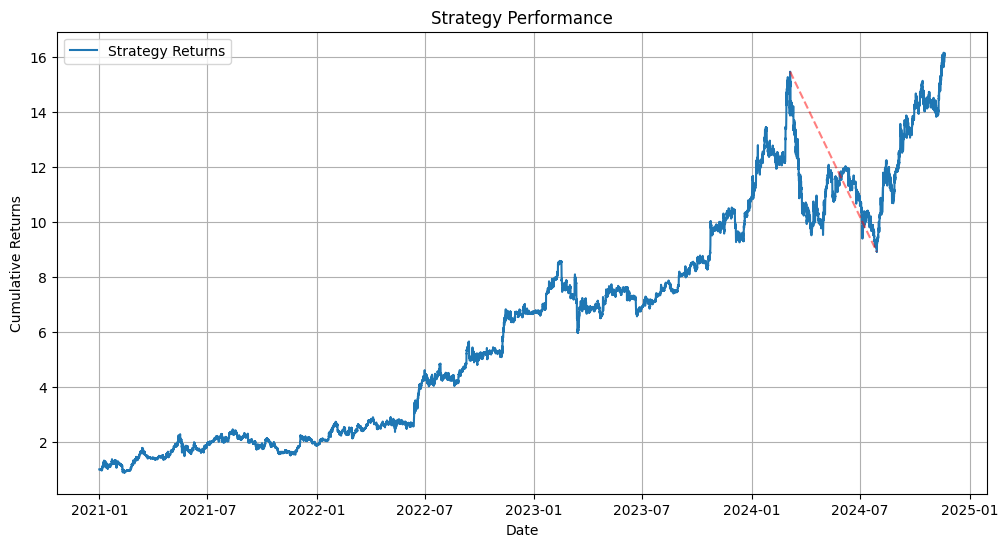

Done


In [29]:

df = compute_alphas('./binance_data/usdt_btc_1h.csv')
df = combined_alpha_signals(df, entry_threshold=1, exit_threshold=0.5, lookback=24)
metrics = calculate_performance_metrics(df)
df.to_csv('./binance_data/usdt_btc_1h_with_alphas.csv', index=False)
print("Done")